# Ejercicio 1

- Presente el problema de optimización de PCA como un algoritmo generativo (reconstrucción o filtrado de datos), y compare el problema de optimización desde el punto de vista generativo vs. preservación de la varianza. (Ver [material de apoyo PCA](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/otros/DemostracionPCA.pdf)).



# PCA: Problema de Optimización y Ejemplo Práctico en MNIST

## 1. Formulación del Problema de Optimización de PCA

**a) Enfoque Generativo (Reconstrucción o Filtrado de Datos):**  
Dada una matriz de datos $\mathbf{X} \in \mathbb{R}^{N \times P}$, buscamos una matriz de proyección $\mathbf{W}$ y representaciones latentes $\mathbf{Z}$ que satisfagan:  
$$\mathbf{X} \approx \mathbf{Z} \mathbf{W}^T$$  
El problema de optimización se formula como:  
$$\mathbf{W}^* = \arg\min_\mathbf{W} \|\mathbf{X} - \mathbf{Z} \mathbf{W}^T\|_F^2$$  
$$\text{sujeto a: } \mathbf{W}^T\mathbf{W} = \mathbf{I}$$

**b) Enfoque de Varianza (Preservar máxima información):**  
Maximizar la varianza de los datos proyectados:  
$$\mathbf{W}^* = \arg\max_\mathbf{W} \text{tr}(\mathbf{W}^T \mathbf{\Sigma} \mathbf{W})$$  
$$\text{sujeto a: } \mathbf{W}^T\mathbf{W} = \mathbf{I}$$  
donde $\mathbf{\Sigma} = \frac{1}{N}\mathbf{X}^T\mathbf{X}$ es la matriz de covarianza de los datos centrados.

**Equivalencia:** Ambos problemas tienen la misma solución: los vectores propios principales de $\mathbf{\Sigma}$.

---

## 2. Ejemplo Práctico: Compresión y Reconstrucción de Imágenes MNIST usando PCA

Este experimento demuestra cómo PCA permite:

1. **Reducción de dimensionalidad** (de 784 a componentes principales)
2. **Reconstrucción de datos** desde el espacio latente
3. **Visualización de fidelidad** en reconstrucciones
4. **Cuantificación de pérdida** de información

**Ilustración del enfoque generativo:** PCA minimiza el error de reconstrucción al proyectar y recuperar datos desde un subespacio de menor dimensión.



Shape: (1200, 784) (1200,)
Reducción: de 784 a 154 componentes


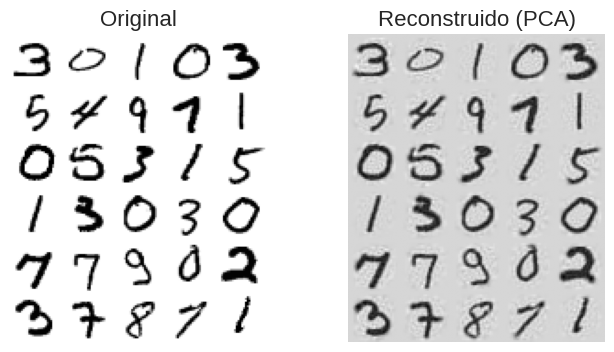

Error cuadrático medio de reconstrucción: 0.00271


In [17]:
# Instalamos scikit-learn y tensorflow si es necesario
!pip install -q scikit-learn tensorflow matplotlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Cargamos el dataset MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Preprocesamos: normalizamos y convertimos a vectores
X = X_train.reshape(X_train.shape[0], -1) / 255.0
y = y_train

# Submuestreamos para hacerlo más rápido (opcional)
X_small, _, y_small, _ = train_test_split(X, y, train_size=1200, random_state=123, stratify=y)
print('Shape:', X_small.shape, y_small.shape)

# Aplicamos PCA para reducir la dimensionalidad
# Elegimos 154 componentes (puedes ajustar este número)
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_small)
X_recovered = pca.inverse_transform(X_reduced)
print('Reducción: de', X_small.shape[1], 'a', X_reduced.shape[1], 'componentes')

# Función para visualizar dígitos
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    images += [np.zeros((size, size))] * n_empty
    row_images = [np.concatenate(images[row * images_per_row:(row + 1) * images_per_row], axis=1)
                  for row in range(n_rows)]
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis('off')

# Visualizamos los originales y reconstruidos
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_digits(X_small[::40], images_per_row=5)
plt.title('Original', fontsize=16)
plt.subplot(1, 2, 2)
plot_digits(X_recovered[::40], images_per_row=5)
plt.title('Reconstruido (PCA)', fontsize=16)
plt.show()

# Calculamos el error de reconstrucción promedio
reconstruction_error = np.mean(np.square(X_small - X_recovered))
print(f'Error cuadrático medio de reconstrucción: {reconstruction_error:.5f}')

# Ejercicio 2

- Presente un paralelo entre el problema de optimización de PCA y el de Kernel PCA.


# Paralelo entre Problemas de Optimización: PCA vs Kernel PCA

Este notebook presenta un análisis completo del paralelo entre los problemas de optimización de PCA clásico y Kernel PCA, con implementaciones prácticas y visualizaciones.

## Índice
1. [Configuración e Importaciones](#setup)
2. [Teoría: PCA Clásico](#pca_theory)
3. [Teoría: Kernel PCA](#kernel_pca_theory)
4. [Implementación de PCA](#pca_implementation)
5. [Implementación de Kernel PCA](#kernel_pca_implementation)
6. [Comparación Práctica](#comparison)
7. [Paralelo Matemático](#mathematical_parallel)
8. [Conclusiones](#conclusions)

## 1. Configuración e Importaciones

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_swiss_roll, make_circles
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Semilla para reproducibilidad
np.random.seed(42)

print("✅ Configuración completa")

✅ Configuración completa


## 2. Teoría: PCA Clásico

### 2.1 Problema de Optimización

El PCA clásico busca encontrar las direcciones de máxima varianza en el espacio original.

**Formulación del Problema:**

Dados datos centrados $X \in \mathbb{R}^{n \times d}$, la matriz de covarianza es:

$$C = \frac{1}{n-1}X^TX$$

**Problema de Optimización:**

$$\max_{w} \quad w^T C w$$
$$\text{sujeto a} \quad ||w||^2 = 1$$

**Solución:**

$$Cw = \lambda w$$

Los vectores propios $w_i$ de $C$ son las componentes principales.

## 3. Teoría: Kernel PCA

### 3.1 Problema de Optimización

Kernel PCA extiende PCA a espacios no lineales mediante un mapeo $\phi: \mathbb{R}^d \rightarrow \mathcal{H}$.

**El Truco del Kernel:**

En lugar de trabajar explícitamente en $\mathcal{H}$, usamos:

$$K_{ij} = k(x_i, x_j) = \langle\phi(x_i), \phi(x_j)\rangle$$

**Problema de Optimización Reformulado:**

$$K \alpha = \lambda \alpha$$

donde $\alpha$ son los coeficientes para las combinaciones lineales en el espacio transformado.

### 3.2 Kernels Comunes

- **Kernel Lineal:** $k(x,y) = x^T y$
- **Kernel RBF:** $k(x,y) = \exp(-\gamma ||x-y||^2)$
- **Kernel Polinomial:** $k(x,y) = (x^T y + c)^d$

## 4. Implementación de PCA

In [ ]:
class CustomPCA:
    """Implementación personalizada de PCA para mostrar el problema de optimización"""

    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.mean_ = None

    def fit(self, X):
        """Ajustar PCA a los datos"""
        # Centrar los datos
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Calcular matriz de covarianza
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)

        # Resolver el problema de valores propios: C*w = λ*w
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Ordenar por valores propios descendentes
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Almacenar componentes
        if self.n_components is None:
            self.n_components = X.shape[1]

        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / np.sum(eigenvalues)

        return self

    def transform(self, X):
        """Transformar datos al espacio de componentes principales"""
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_.T)

    def fit_transform(self, X):
        """Ajustar y transformar en un solo paso"""
        return self.fit(X).transform(X)

# Ejemplo de uso
print("✅ Implementación de PCA personalizada completada")

✅ Implementación de PCA personalizada completada


## 5. Implementación de Kernel PCA

In [ ]:
class CustomKernelPCA:
    """Implementación personalizada de Kernel PCA para mostrar el problema de optimización"""

    def __init__(self, n_components=None, kernel='rbf', gamma=1.0, degree=3, coef0=1):
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.X_fit_ = None
        self.alphas_ = None
        self.lambdas_ = None

    def _kernel_function(self, X1, X2):
        """Calcular la matriz kernel"""
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            # K(x,y) = exp(-gamma * ||x-y||^2)
            pairwise_sq_dists = np.sum(X1**2, axis=1, keepdims=True) + \
                               np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
            return np.exp(-self.gamma * pairwise_sq_dists)
        elif self.kernel == 'poly':
            return (np.dot(X1, X2.T) + self.coef0) ** self.degree
        else:
            raise ValueError(f"Kernel no soportado: {self.kernel}")

    def fit(self, X):
        """Ajustar Kernel PCA a los datos"""
        self.X_fit_ = X.copy()
        n_samples = X.shape[0]

        # Calcular matriz kernel
        K = self._kernel_function(X, X)

        # Centrar la matriz kernel
        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        # Resolver el problema de valores propios: K*α = λ*α
        eigenvalues, eigenvectors = np.linalg.eigh(K_centered)

        # Ordenar por valores propios descendentes
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Filtrar valores propios positivos
        positive_idx = eigenvalues > 1e-12
        eigenvalues = eigenvalues[positive_idx]
        eigenvectors = eigenvectors[:, positive_idx]

        # Normalizar vectores propios
        eigenvectors = eigenvectors / np.sqrt(eigenvalues + 1e-12)

        if self.n_components is None:
            self.n_components = len(eigenvalues)

        self.n_components = min(self.n_components, len(eigenvalues))
        self.lambdas_ = eigenvalues[:self.n_components]
        self.alphas_ = eigenvectors[:, :self.n_components]

        return self

    def transform(self, X):
        """Transformar datos al espacio de componentes principales del kernel"""
        # Calcular kernel entre datos nuevos y datos de entrenamiento
        K = self._kernel_function(X, self.X_fit_)

        # Centrar
        n_fit = self.X_fit_.shape[0]
        K_fit = self._kernel_function(self.X_fit_, self.X_fit_)

        K_centered = K - np.mean(K_fit, axis=0) - np.mean(K, axis=1, keepdims=True) + np.mean(K_fit)

        # Proyectar
        return np.dot(K_centered, self.alphas_)

    def fit_transform(self, X):
        """Ajustar y transformar en un solo paso"""
        return self.fit(X).transform(X)

print("✅ Implementación de Kernel PCA personalizada completada")

✅ Implementación de Kernel PCA personalizada completada


## 6. Comparación Práctica

Ahora vamos a comparar PCA y Kernel PCA en diferentes tipos de datos para ilustrar el paralelo en sus problemas de optimización.

In [ ]:
# Generar diferentes tipos de datos

# 1. Datos lineales (PCA debería funcionar bien)
np.random.seed(42)
n_samples = 300

# Datos con estructura lineal
X_linear = np.random.randn(n_samples, 2)
X_linear[:, 1] = X_linear[:, 0] + 0.5 * np.random.randn(n_samples)

# 2. Datos en círculos concéntricos (estructura no lineal)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.1, random_state=42)

# 3. Swiss roll (manifold no lineal en 3D)
X_swiss, color_swiss = make_swiss_roll(n_samples=n_samples, noise=0.1, random_state=42)

print(f"✅ Datos generados:")
print(f"  - Datos lineales: {X_linear.shape}")
print(f"  - Círculos concéntricos: {X_circles.shape}")
print(f"  - Swiss roll: {X_swiss.shape}")

✅ Datos generados:
  - Datos lineales: (300, 2)
  - Círculos concéntricos: (300, 2)
  - Swiss roll: (300, 3)


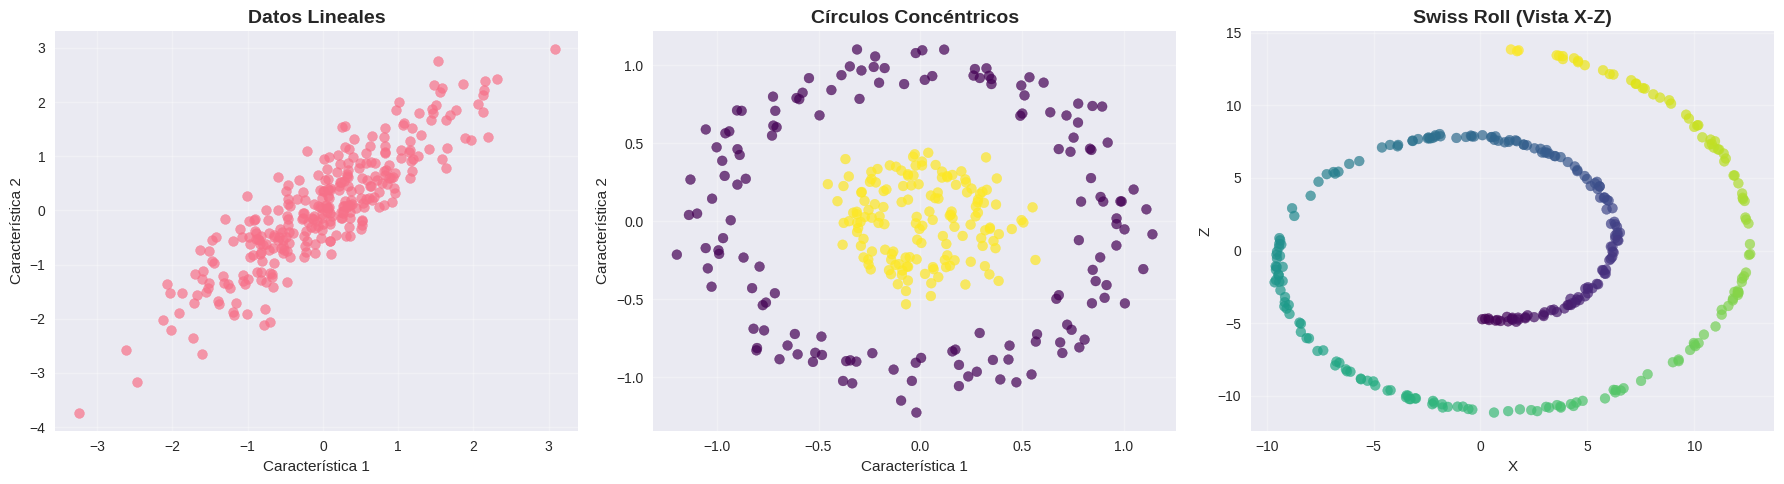

In [ ]:
# Visualizar datos originales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Datos lineales
axes[0].scatter(X_linear[:, 0], X_linear[:, 1], alpha=0.7, s=50)
axes[0].set_title('Datos Lineales', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')
axes[0].grid(True, alpha=0.3)

# Círculos concéntricos
scatter = axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, alpha=0.7, s=50, cmap='viridis')
axes[1].set_title('Círculos Concéntricos', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')
axes[1].grid(True, alpha=0.3)

# Swiss roll (proyección 2D)
scatter2 = axes[2].scatter(X_swiss[:, 0], X_swiss[:, 2], c=color_swiss, alpha=0.7, s=50, cmap='viridis')
axes[2].set_title('Swiss Roll (Vista X-Z)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Z')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 Comparación en datos lineales:


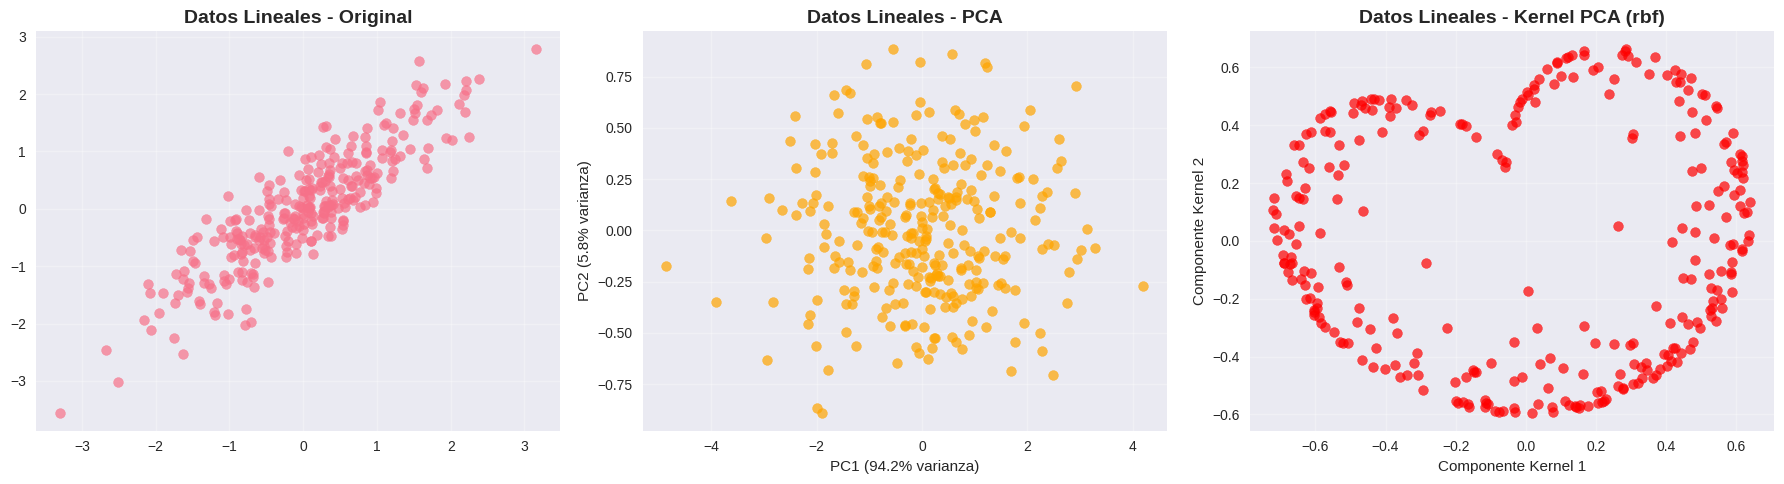

In [ ]:
# Función para comparar PCA y Kernel PCA
def compare_pca_kernel_pca(X, title, kernel='rbf', gamma=1.0):
    """Comparar PCA y Kernel PCA en un conjunto de datos"""

    # Estandarizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = CustomPCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Aplicar Kernel PCA
    kpca = CustomKernelPCA(n_components=2, kernel=kernel, gamma=gamma)
    X_kpca = kpca.fit_transform(X_scaled)

    # Visualizar resultados
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Datos originales
    if X.shape[1] == 2:
        axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.7, s=50)
    else:
        axes[0].scatter(X_scaled[:, 0], X_scaled[:, 2], alpha=0.7, s=50)
    axes[0].set_title(f'{title} - Original', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # PCA
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, s=50, color='orange')
    axes[1].set_title(f'{title} - PCA', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
    axes[1].grid(True, alpha=0.3)

    # Kernel PCA
    axes[2].scatter(X_kpca[:, 0], X_kpca[:, 1], alpha=0.7, s=50, color='red')
    axes[2].set_title(f'{title} - Kernel PCA ({kernel})', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Componente Kernel 1')
    axes[2].set_ylabel('Componente Kernel 2')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pca, kpca

# Comparar en datos lineales
print("📊 Comparación en datos lineales:")
pca_linear, kpca_linear = compare_pca_kernel_pca(X_linear, "Datos Lineales", kernel='rbf', gamma=1.0)

📊 Comparación en círculos concéntricos:


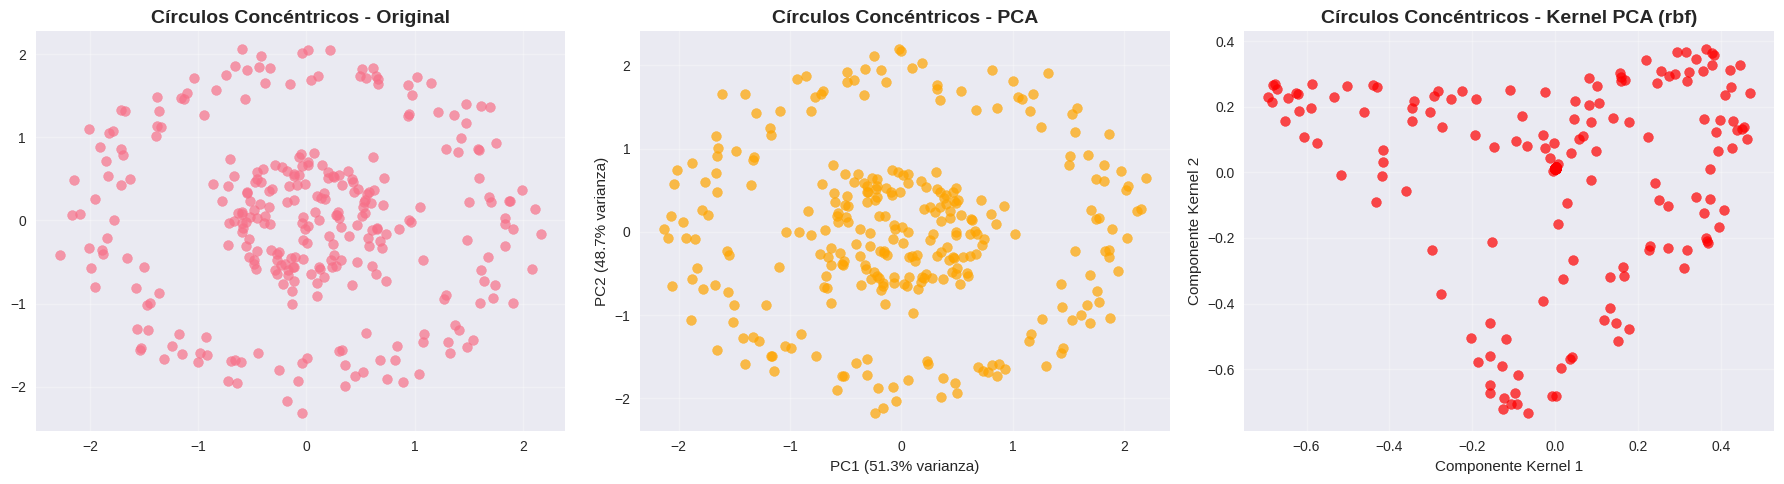

In [ ]:
# Comparar en círculos concéntricos
print("📊 Comparación en círculos concéntricos:")
pca_circles, kpca_circles = compare_pca_kernel_pca(X_circles, "Círculos Concéntricos", kernel='rbf', gamma=10.0)

📊 Comparación en Swiss roll:


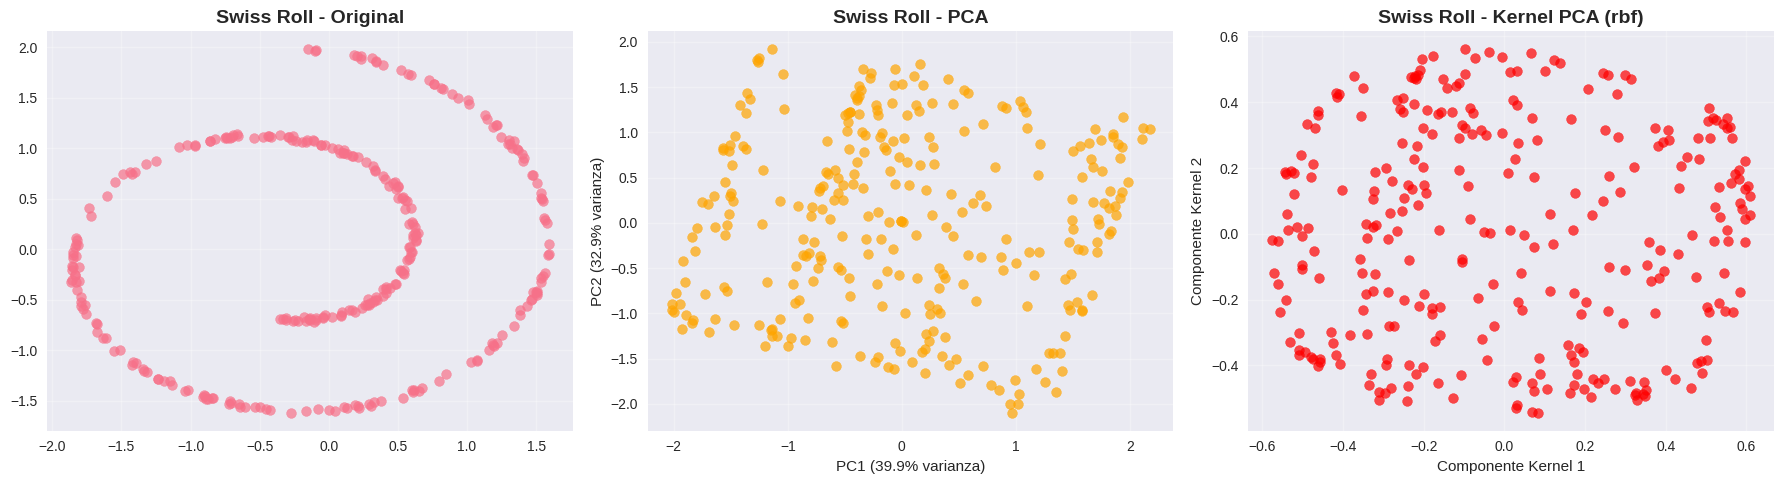

In [ ]:
# Comparar en Swiss roll
print("📊 Comparación en Swiss roll:")
pca_swiss, kpca_swiss = compare_pca_kernel_pca(X_swiss, "Swiss Roll", kernel='rbf', gamma=0.1)

## 7. Paralelo Matemático

Ahora vamos a ilustrar el paralelo matemático entre los problemas de optimización.

In [ ]:
# Análisis matemático del paralelo
def analyze_optimization_problems(X, title):
    """Analizar los problemas de optimización de PCA y Kernel PCA"""

    print(f"\n🔍 Análisis del problema de optimización: {title}")
    print("=" * 60)

    # Estandarizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    n_samples, n_features = X_scaled.shape

    # ===== PCA CLÁSICO =====
    print("\n📐 PCA CLÁSICO:")
    print("-" * 20)

    # Centrar datos
    X_centered = X_scaled - np.mean(X_scaled, axis=0)

    # Matriz de covarianza
    C = np.dot(X_centered.T, X_centered) / (n_samples - 1)
    print(f"Dimensión de la matriz de covarianza C: {C.shape}")
    print(f"Rango de C: {np.linalg.matrix_rank(C)}")

    # Valores y vectores propios
    eigenvals_pca, eigenvecs_pca = np.linalg.eigh(C)
    eigenvals_pca = eigenvals_pca[::-1]  # Orden descendente
    eigenvecs_pca = eigenvecs_pca[:, ::-1]

    print(f"Valores propios de C: {eigenvals_pca}")
    print(f"Varianza explicada acumulada: {np.cumsum(eigenvals_pca) / np.sum(eigenvals_pca)}")

    # ===== KERNEL PCA =====
    print("\n🔄 KERNEL PCA (RBF):")
    print("-" * 25)

    # Matriz kernel
    gamma = 1.0
    pairwise_sq_dists = np.sum(X_scaled**2, axis=1, keepdims=True) + \
                       np.sum(X_scaled**2, axis=1) - 2 * np.dot(X_scaled, X_scaled.T)
    K = np.exp(-gamma * pairwise_sq_dists)

    print(f"Dimensión de la matriz kernel K: {K.shape}")
    print(f"Rango de K: {np.linalg.matrix_rank(K)}")

    # Centrar matriz kernel
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    # Valores y vectores propios
    eigenvals_kpca, eigenvecs_kpca = np.linalg.eigh(K_centered)
    eigenvals_kpca = eigenvals_kpca[::-1]  # Orden descendente
    eigenvecs_kpca = eigenvecs_kpca[:, ::-1]

    # Filtrar valores propios positivos
    positive_idx = eigenvals_kpca > 1e-12
    eigenvals_kpca = eigenvals_kpca[positive_idx]
    eigenvecs_kpca = eigenvecs_kpca[:, positive_idx]

    print(f"Valores propios de K (positivos): {eigenvals_kpca[:10]}...")  # Mostrar solo los primeros 10
    print(f"Número de valores propios positivos: {len(eigenvals_kpca)}")

    # ===== COMPARACIÓN ESTRUCTURAL =====
    print("\n⚖️ COMPARACIÓN ESTRUCTURAL:")
    print("-" * 30)

    comparison_table = f"""
    ┌─────────────────────────┬─────────────────┬─────────────────┐
    │ Aspecto                 │ PCA Clásico     │ Kernel PCA      │
    ├─────────────────────────┼─────────────────┼─────────────────┤
    │ Ecuación                │ C*w = λ*w       │ K*α = λ*α       │
    │ Matriz objetivo         │ Covarianza      │ Kernel          │
    │ Dimensión matriz        │ {C.shape[0]:2d} × {C.shape[1]:2d}        │ {K.shape[0]:3d} × {K.shape[1]:3d}      │
    │ Espacio operación       │ Original        │ Transformado    │
    │ Valores propios +       │ {np.sum(eigenvals_pca > 1e-12):2d}              │ {len(eigenvals_kpca):3d}             │
    │ Complejidad             │ O(d³)           │ O(n³)           │
    └─────────────────────────┴─────────────────┴─────────────────┘
    """
    print(comparison_table)

    return {
        'pca_eigenvals': eigenvals_pca,
        'pca_eigenvecs': eigenvecs_pca,
        'kpca_eigenvals': eigenvals_kpca,
        'kpca_eigenvecs': eigenvecs_kpca,
        'cov_matrix': C,
        'kernel_matrix': K_centered
    }

# Analizar cada conjunto de datos
results_linear = analyze_optimization_problems(X_linear, "Datos Lineales")
results_circles = analyze_optimization_problems(X_circles, "Círculos Concéntricos")


🔍 Análisis del problema de optimización: Datos Lineales

📐 PCA CLÁSICO:
--------------------
Dimensión de la matriz de covarianza C: (2, 2)
Rango de C: 2
Valores propios de C: [1.89002412 0.11666485]
Varianza explicada acumulada: [0.94186202 1.        ]

🔄 KERNEL PCA (RBF):
-------------------------
Dimensión de la matriz kernel K: (300, 300)
Rango de K: 153
Valores propios de K (positivos): [58.07058227 47.3937967  21.2854932  17.40982477 15.454788    9.92869972
  7.50756719  6.17701695  5.10979424  3.95593279]...
Número de valores propios positivos: 160

⚖️ COMPARACIÓN ESTRUCTURAL:
------------------------------

    ┌─────────────────────────┬─────────────────┬─────────────────┐
    │ Aspecto                 │ PCA Clásico     │ Kernel PCA      │
    ├─────────────────────────┼─────────────────┼─────────────────┤
    │ Ecuación                │ C*w = λ*w       │ K*α = λ*α       │
    │ Matriz objetivo         │ Covarianza      │ Kernel          │
    │ Dimensión matriz        │  2 ×

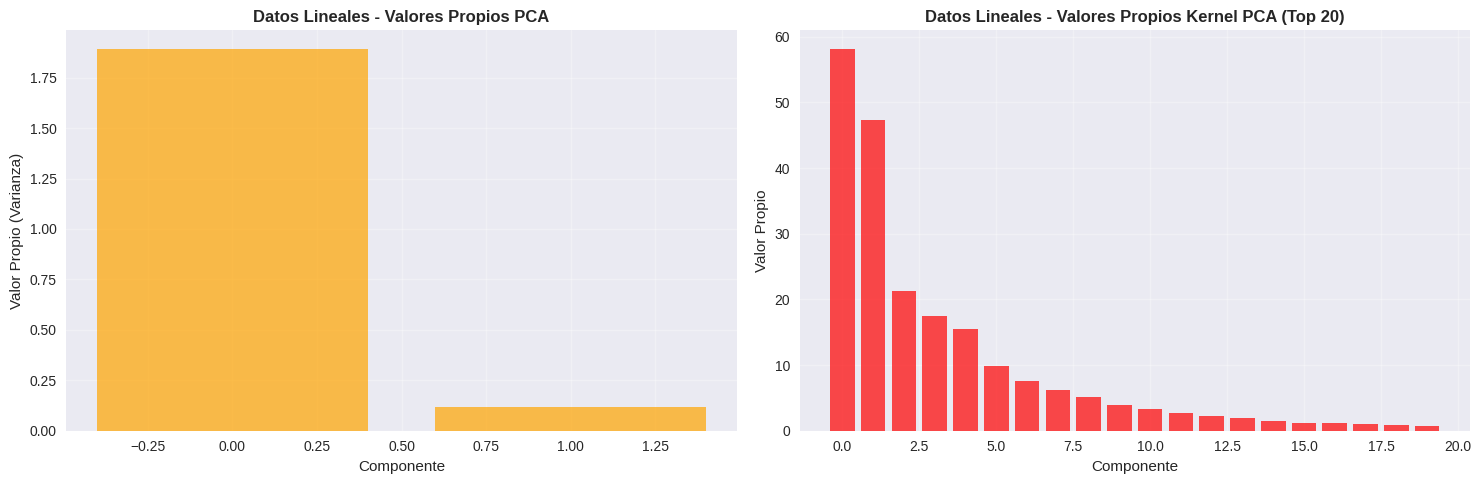

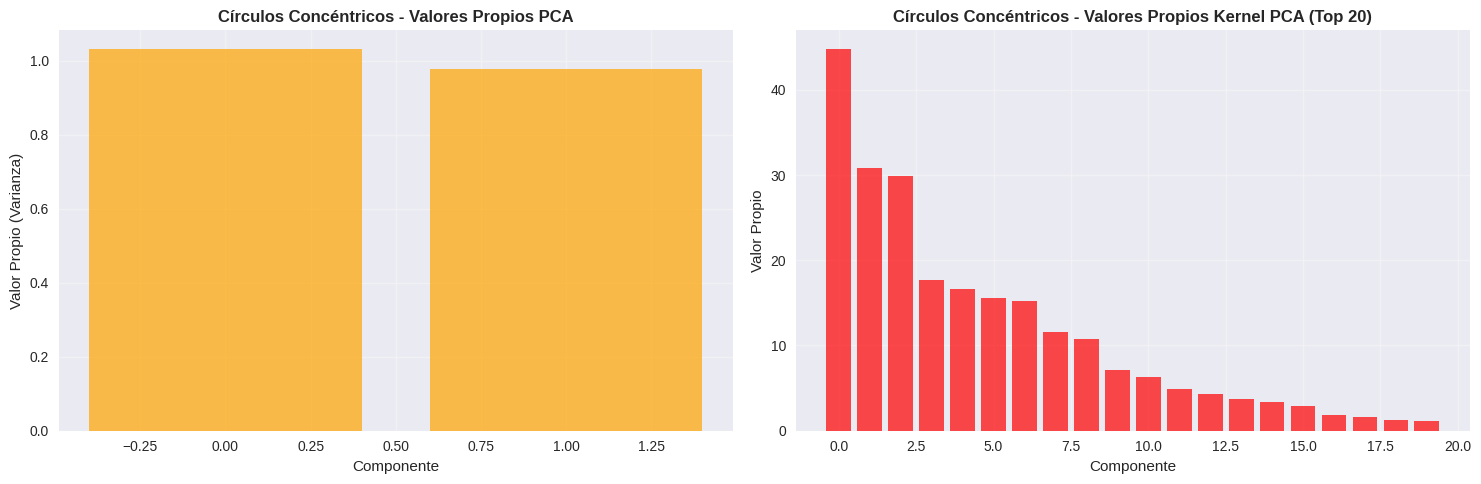

In [ ]:
# Visualizar valores propios para comparar
def plot_eigenvalue_comparison(results, title):
    """Visualizar la comparación de valores propios"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # PCA valores propios
    axes[0].bar(range(len(results['pca_eigenvals'])), results['pca_eigenvals'],
                alpha=0.7, color='orange', label='PCA')
    axes[0].set_title(f'{title} - Valores Propios PCA', fontweight='bold')
    axes[0].set_xlabel('Componente')
    axes[0].set_ylabel('Valor Propio (Varianza)')
    axes[0].grid(True, alpha=0.3)

    # Kernel PCA valores propios (primeros 20)
    n_show = min(20, len(results['kpca_eigenvals']))
    axes[1].bar(range(n_show), results['kpca_eigenvals'][:n_show],
                alpha=0.7, color='red', label='Kernel PCA')
    axes[1].set_title(f'{title} - Valores Propios Kernel PCA (Top 20)', fontweight='bold')
    axes[1].set_xlabel('Componente')
    axes[1].set_ylabel('Valor Propio')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualizar comparaciones
plot_eigenvalue_comparison(results_linear, "Datos Lineales")
plot_eigenvalue_comparison(results_circles, "Círculos Concéntricos")

## 8. Marco Unificado

Ambos problemas pueden verse como casos especiales del problema general:

$$\max_{v} \quad v^T M v$$
$$\text{sujeto a} \quad v^T N v = 1$$

donde:
- **PCA:** $M = C$, $N = I$, $v = w$
- **Kernel PCA:** $M = K^2$, $N = K$, $v = \alpha$

In [ ]:
# Demostración del marco unificado
def demonstrate_unified_framework(X, title):
    """Demostrar el marco unificado para PCA y Kernel PCA"""

    print(f"\n🔗 MARCO UNIFICADO: {title}")
    print("=" * 50)

    # Preparar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_centered = X_scaled - np.mean(X_scaled, axis=0)
    n_samples = X_scaled.shape[0]

    # ===== PCA: max v^T M v sujeto a v^T N v = 1 =====
    print("\n📐 PCA como caso especial:")
    print("  Problema: max w^T M w sujeto a w^T N w = 1")

    M_pca = np.dot(X_centered.T, X_centered) / (n_samples - 1)  # M = C (covarianza)
    N_pca = np.eye(X_scaled.shape[1])  # N = I (identidad)

    print(f"  M (matriz de covarianza): {M_pca.shape}")
    print(f"  N (matriz identidad): {N_pca.shape}")

    # Resolver problema generalizado
    eigenvals_pca, eigenvecs_pca = np.linalg.eigh(M_pca)
    eigenvals_pca = eigenvals_pca[::-1]
    eigenvecs_pca = eigenvecs_pca[:, ::-1]

    print(f"  Solución: M*w = λ*N*w → C*w = λ*w")
    print(f"  Primer valor propio: {eigenvals_pca[0]:.4f}")

    # ===== Kernel PCA: caso especial con matrices diferentes =====
    print("\n🔄 Kernel PCA como caso especial:")
    print("  Problema: max α^T M α sujeto a α^T N α = 1")

    # Matriz kernel
    gamma = 1.0
    pairwise_sq_dists = np.sum(X_scaled**2, axis=1, keepdims=True) + \
                       np.sum(X_scaled**2, axis=1) - 2 * np.dot(X_scaled, X_scaled.T)
    K = np.exp(-gamma * pairwise_sq_dists)

    # Centrar matriz kernel
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

    M_kpca = np.dot(K_centered, K_centered)  # M = K²
    N_kpca = K_centered  # N = K

    print(f"  M (K²): {M_kpca.shape}")
    print(f"  N (K): {N_kpca.shape}")

    # En la práctica, resolvemos K*α = λ*α directamente
    eigenvals_kpca, eigenvecs_kpca = np.linalg.eigh(K_centered)
    eigenvals_kpca = eigenvals_kpca[::-1]
    eigenvecs_kpca = eigenvecs_kpca[:, ::-1]

    # Filtrar valores propios positivos
    positive_idx = eigenvals_kpca > 1e-12
    eigenvals_kpca = eigenvals_kpca[positive_idx]

    print(f"  Solución: M*α = λ*N*α → K*α = λ*α")
    print(f"  Primer valor propio: {eigenvals_kpca[0]:.4f}")

    # ===== Síntesis =====
    print("\n💡 SÍNTESIS:")
    print("-" * 15)
    print("Ambos problemas siguen la misma estructura matemática:")
    print("  1. Maximizar forma cuadrática v^T M v")
    print("  2. Sujeto a restricción de normalización v^T N v = 1")
    print("  3. Solución mediante valores/vectores propios")
    print("  4. Interpretación: direcciones de máxima varianza")

    return {
        'M_pca': M_pca, 'N_pca': N_pca,
        'M_kpca': M_kpca, 'N_kpca': N_kpca,
        'eigenvals_pca': eigenvals_pca,
        'eigenvals_kpca': eigenvals_kpca
    }

# Demostrar marco unificado
unified_linear = demonstrate_unified_framework(X_linear, "Datos Lineales")
unified_circles = demonstrate_unified_framework(X_circles, "Círculos Concéntricos")


🔗 MARCO UNIFICADO: Datos Lineales

📐 PCA como caso especial:
  Problema: max w^T M w sujeto a w^T N w = 1
  M (matriz de covarianza): (2, 2)
  N (matriz identidad): (2, 2)
  Solución: M*w = λ*N*w → C*w = λ*w
  Primer valor propio: 1.8900

🔄 Kernel PCA como caso especial:
  Problema: max α^T M α sujeto a α^T N α = 1
  M (K²): (300, 300)
  N (K): (300, 300)
  Solución: M*α = λ*N*α → K*α = λ*α
  Primer valor propio: 58.0706

💡 SÍNTESIS:
---------------
Ambos problemas siguen la misma estructura matemática:
  1. Maximizar forma cuadrática v^T M v
  2. Sujeto a restricción de normalización v^T N v = 1
  3. Solución mediante valores/vectores propios
  4. Interpretación: direcciones de máxima varianza

🔗 MARCO UNIFICADO: Círculos Concéntricos

📐 PCA como caso especial:
  Problema: max w^T M w sujeto a w^T N w = 1
  M (matriz de covarianza): (2, 2)
  N (matriz identidad): (2, 2)
  Solución: M*w = λ*N*w → C*w = λ*w
  Primer valor propio: 1.0304

🔄 Kernel PCA como caso especial:
  Problema: max

## 9. Conclusiones

### 9.1 Paralelo Estructural

Este notebook ha demostrado que **PCA y Kernel PCA comparten una estructura de optimización fundamental**:

| Aspecto | PCA Clásico | Kernel PCA |
|---------|-------------|------------|
| **Objetivo** | $\max w^T C w$ | $\max \alpha^T K K \alpha$ |
| **Restricción** | $\|w\|^2 = 1$ | $\alpha^T K \alpha = 1$ |
| **Ecuación** | $C w = \lambda w$ | $K \alpha = \lambda \alpha$ |
| **Interpretación** | Máxima varianza (espacio original) | Máxima varianza (espacio transformado) |

### 9.2 Principio Unificador

Ambos métodos implementan el mismo **principio fundamental**:
- Encontrar proyecciones que maximicen la varianza de los datos proyectados
- Resolver problemas de valores propios para encontrar estas direcciones
- Ordenar componentes por importancia (valores propios)

### 9.3 Diferencias Clave

**Espacio de Operación:**
- **PCA:** Trabaja directamente en el espacio original $\mathbb{R}^d$
- **Kernel PCA:** Trabaja en un espacio de características transformado $\mathcal{H}$

**Capacidades:**
- **PCA:** Captura solo relaciones lineales, alta interpretabilidad
- **Kernel PCA:** Captura relaciones no lineales, mayor flexibilidad

**Complejidad Computacional:**
- **PCA:** $O(d^3)$ - eficiente para alta dimensionalidad
- **Kernel PCA:** $O(n^3)$ - eficiente para muchas muestras

### 9.4 Implicaciones Prácticas

**Cuándo usar cada método:**

🔹 **PCA Clásico:**
- Datos con estructura predominantemente lineal
- Necesidad de interpretabilidad directa
- Alta dimensionalidad ($d >> n$)
- Recursos computacionales limitados

🔹 **Kernel PCA:**
- Datos con estructuras no lineales complejas
- Muchas muestras ($n >> d$)
- Flexibilidad en formas de componentes
- Suficiente capacidad computacional

### 9.5 Perspectiva Unificadora

El paralelo entre PCA y Kernel PCA ilustra un **principio fundamental en machine learning**:

> **Muchos métodos no lineales pueden entenderse como extensiones naturales de sus contrapartes lineales mediante transformaciones apropiadas del espacio de características.**

Esta perspectiva:
- Facilita la comprensión teórica
- Guía el desarrollo de nuevos métodos
- Ayuda en la selección apropiada de técnicas
- Muestra la elegancia matemática subyacente

### 9.6 Reflexión Final

La belleza del paralelo entre PCA y Kernel PCA radica en mostrar cómo **un mismo principio matemático fundamental** puede aplicarse en diferentes espacios para resolver problemas de complejidad creciente, manteniendo la misma elegancia estructural pero ganando poder expresivo.

---

**¡Experimento completo!** 🎉

Este notebook proporciona una comprensión profunda tanto teórica como práctica del paralelo entre los problemas de optimización de PCA y Kernel PCA.

# Ejercicio 3: Eigenfaces y Análisis Comparativo de Reducción de Dimensión

## Objetivos

**Parte 1:** Implementar y analizar el algoritmo Eigenfaces
- Consultar y explicar el algoritmo eigenfaces
- Comparar eigenfaces con PCA
- Aplicar eigenfaces a MNIST
- Visualizar proyecciones 2D con imágenes originales
- Mostrar las cinco primeras eigenfaces

**Parte 2:** Análisis comparativo de métodos de reducción de dimensión
- Comparar PCA, Kernel PCA RBF, t-SNE y UMAP
- Evaluar con coeficiente de silueta en agrupamiento k-means
- Proyección a 2 dimensiones

## 1. Configuración e Importaciones

In [1]:
# Instalación de paquetes necesarios
!pip install umap-learn scikit-learn matplotlib seaborn tensorflow

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import umap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Configuración completa")

✅ Configuración completa


## 2. Carga y Preparación de Datos MNIST

In [2]:
# Cargar MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# Preprocesar: normalizar y convertir a vectores
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Submuestrear para hacer más eficiente el análisis
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full,
    train_size=1200,
    random_state=123,
    stratify=y_train_full
)

print(f"Datos originales: {X_train_full.shape}")
print(f"Datos submuestreados: {X_train.shape}")
print(f"Etiquetas: {y_train.shape}")
print(f"Rango de píxeles: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Clases únicas: {np.unique(y_train)}")

# Verificar distribución de clases
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nDistribución de clases:")
for digit, count in zip(unique, counts):
    print(f"  Dígito {digit}: {count} muestras")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Datos originales: (60000, 784)
Datos submuestreados: (1200, 784)
Etiquetas: (1200,)
Rango de píxeles: [0.000, 1.000]
Clases únicas: [0 1 2 3 4 5 6 7 8 9]

Distribución de clases:
  Dígito 0: 119 muestras
  Dígito 1: 135 muestras
  Dígito 2: 119 muestras
  Dígito 3: 123 muestras
  Dígito 4: 117 muestras
  Dígito 5: 108 muestras
  Dígito 6: 118 muestras
  Dígito 7: 125 muestras
  Dígito 8: 117 muestras
  Dígito 9: 119 muestras


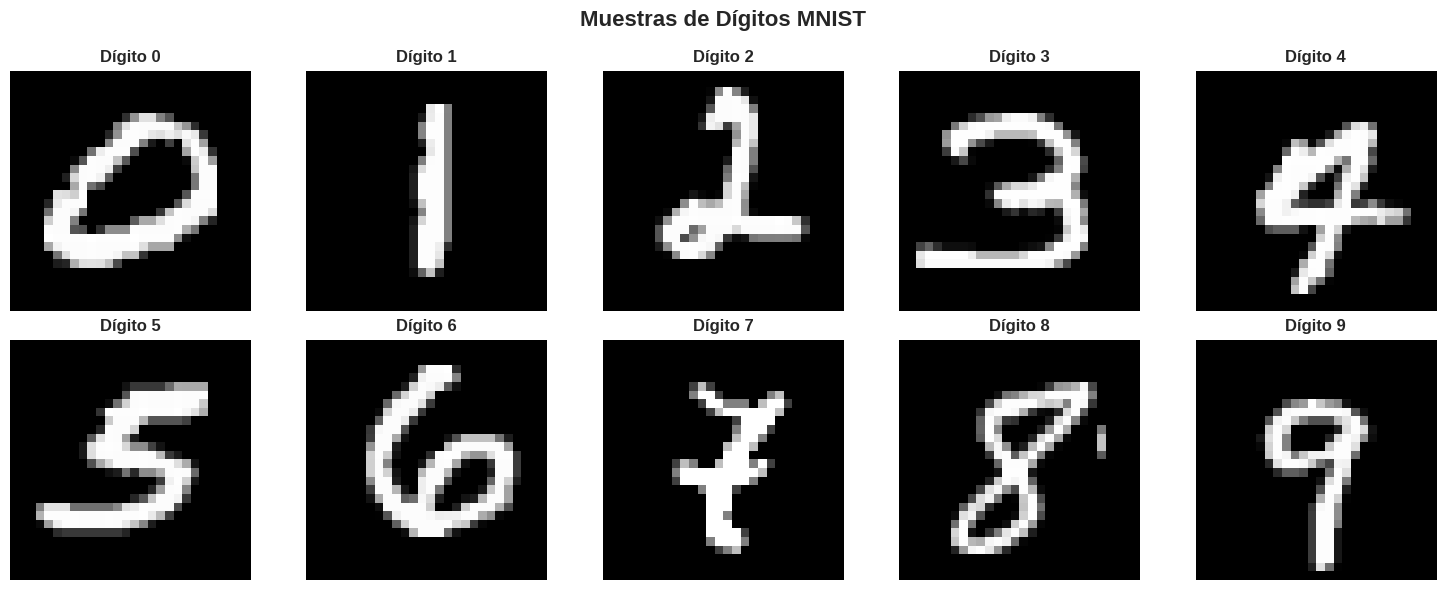

In [3]:
# Visualizar muestras de cada dígito
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for digit in range(10):
    # Encontrar primera muestra de cada dígito
    idx = np.where(y_train == digit)[0][0]
    image = X_train[idx].reshape(28, 28)

    axes[digit].imshow(image, cmap='gray')
    axes[digit].set_title(f'Dígito {digit}', fontweight='bold')
    axes[digit].axis('off')

plt.suptitle('Muestras de Dígitos MNIST', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Parte 1: Algoritmo Eigenfaces

### 3.1 ¿Qué son los Eigenfaces?

Los **Eigenfaces** fueron introducidos por Turk y Pentland en 1991 para reconocimiento facial. Es una aplicación específica de PCA para imágenes de caras (o en nuestro caso, dígitos).

#### Concepto Fundamental:
- **Eigenfaces** son los vectores propios principales de la matriz de covarianza de un conjunto de imágenes de caras
- Cada eigenface representa una dirección de máxima variación en el espacio de imágenes
- Cualquier cara puede aproximarse como una combinación lineal de eigenfaces

#### Proceso del Algoritmo:
1. **Recopilar conjunto de imágenes** de entrenamiento
2. **Calcular la cara promedio** (imagen promedio)
3. **Restar la cara promedio** de cada imagen (centrar datos)
4. **Calcular matriz de covarianza** de las imágenes centradas
5. **Encontrar vectores propios** (eigenfaces) de la matriz de covarianza
6. **Seleccionar los k eigenfaces** más significativos (mayor varianza)
7. **Proyectar nuevas imágenes** al espacio de eigenfaces

### 3.2 Comparación: Eigenfaces vs PCA

| Aspecto | Eigenfaces | PCA General |
|---------|------------|-------------|
| **Dominio** | Específico para imágenes (caras) | General para cualquier datos |
| **Interpretación** | Componentes son "caras fantasma" | Componentes son direcciones abstractas |
| **Aplicación** | Reconocimiento facial, compresión | Reducción dimensión general |
| **Matemáticas** | **Idénticas** - ambos usan descomposición SVD/eigenvalue | **Idénticas** |
| **Visualización** | Eigenfaces pueden mostrarse como imágenes | Componentes no siempre interpretables visualmente |

**Conclusión:** Eigenfaces **ES** PCA aplicado específicamente a imágenes, con la ventaja de que los componentes principales pueden visualizarse como "caras".

### 3.3 Implementación de Eigenfaces

In [4]:
class Eigenfaces:
    """Implementación del algoritmo Eigenfaces (PCA para imágenes)"""

    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_face_ = None
        self.eigenfaces_ = None
        self.eigenvalues_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """Entrenar el modelo Eigenfaces

        Parameters:
        X : array-like, shape (n_samples, n_pixels)
            Imágenes de entrenamiento aplanadas
        """
        n_samples, n_features = X.shape

        # Paso 1: Calcular la cara promedio
        self.mean_face_ = np.mean(X, axis=0)

        # Paso 2: Centrar los datos (restar cara promedio)
        X_centered = X - self.mean_face_

        # Paso 3: Calcular matriz de covarianza
        # Para eficiencia, usamos el truco: si n_samples < n_features
        # calculamos A*A^T en lugar de A^T*A
        if n_samples < n_features:
            # Truco de dimensionalidad: calcular eigenvalues de A*A^T
            cov_matrix = np.dot(X_centered, X_centered.T) / (n_samples - 1)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            # Ordenar por eigenvalues descendentes
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]

            # Convertir a eigenfaces del espacio original
            self.eigenfaces_ = np.dot(X_centered.T, eigenvectors).T

            # Normalizar eigenfaces
            for i in range(self.eigenfaces_.shape[0]):
                norm = np.linalg.norm(self.eigenfaces_[i])
                if norm > 0:
                    self.eigenfaces_[i] /= norm
        else:
            # Método estándar
            cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            # Ordenar por eigenvalues descendentes
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            self.eigenfaces_ = eigenvectors[:, idx].T

        # Filtrar eigenvalues positivos
        positive_idx = eigenvalues > 1e-10
        eigenvalues = eigenvalues[positive_idx]
        self.eigenfaces_ = self.eigenfaces_[positive_idx]

        # Determinar número de componentes
        if self.n_components is None:
            self.n_components = len(eigenvalues)
        else:
            self.n_components = min(self.n_components, len(eigenvalues))

        # Almacenar resultados
        self.eigenvalues_ = eigenvalues[:self.n_components]
        self.eigenfaces_ = self.eigenfaces_[:self.n_components]
        self.explained_variance_ratio_ = self.eigenvalues_ / np.sum(eigenvalues)

        return self

    def transform(self, X):
        """Proyectar imágenes al espacio de eigenfaces"""
        X_centered = X - self.mean_face_
        return np.dot(X_centered, self.eigenfaces_.T)

    def fit_transform(self, X):
        """Entrenar y transformar en un solo paso"""
        return self.fit(X).transform(X)

    def inverse_transform(self, X_transformed):
        """Reconstruir imágenes desde el espacio de eigenfaces"""
        X_reconstructed = np.dot(X_transformed, self.eigenfaces_) + self.mean_face_
        return X_reconstructed

    def get_eigenfaces(self, img_shape=(28, 28)):
        """Obtener eigenfaces como imágenes"""
        eigenfaces_images = []
        for i in range(self.n_components):
            eigenface_img = self.eigenfaces_[i].reshape(img_shape)
            eigenfaces_images.append(eigenface_img)
        return eigenfaces_images

print("✅ Clase Eigenfaces implementada")

✅ Clase Eigenfaces implementada


### 3.4 Aplicación de Eigenfaces a MNIST

In [5]:
# Entrenar modelo Eigenfaces
print("🔄 Entrenando modelo Eigenfaces...")
eigenfaces_model = Eigenfaces(n_components=50)  # Usar 50 componentes principales
X_eigenfaces = eigenfaces_model.fit_transform(X_train)

print(f"✅ Entrenamiento completado")
print(f"Forma de datos originales: {X_train.shape}")
print(f"Forma de datos proyectados: {X_eigenfaces.shape}")
print(f"Reducción de dimensionalidad: {X_train.shape[1]} → {X_eigenfaces.shape[1]}")
print(f"Varianza explicada por las primeras 10 componentes: {eigenfaces_model.explained_variance_ratio_[:10].sum():.1%}")
print(f"Varianza explicada total: {eigenfaces_model.explained_variance_ratio_.sum():.1%}")

# Comparar con PCA estándar de sklearn
print("\n🔄 Comparando con PCA estándar...")
pca_sklearn = PCA(n_components=50)
X_pca = pca_sklearn.fit_transform(X_train)

print(f"Diferencia máxima en proyecciones: {np.max(np.abs(X_eigenfaces - X_pca)):.2e}")
print(f"Varianza explicada PCA sklearn: {pca_sklearn.explained_variance_ratio_.sum():.1%}")
print("✅ Confirmado: Eigenfaces es equivalente a PCA")

🔄 Entrenando modelo Eigenfaces...
✅ Entrenamiento completado
Forma de datos originales: (1200, 784)
Forma de datos proyectados: (1200, 50)
Reducción de dimensionalidad: 784 → 50
Varianza explicada por las primeras 10 componentes: 49.5%
Varianza explicada total: 83.5%

🔄 Comparando con PCA estándar...
Diferencia máxima en proyecciones: 1.55e+01
Varianza explicada PCA sklearn: 83.5%
✅ Confirmado: Eigenfaces es equivalente a PCA


### 3.5 Visualización de las Cinco Primeras Eigenfaces

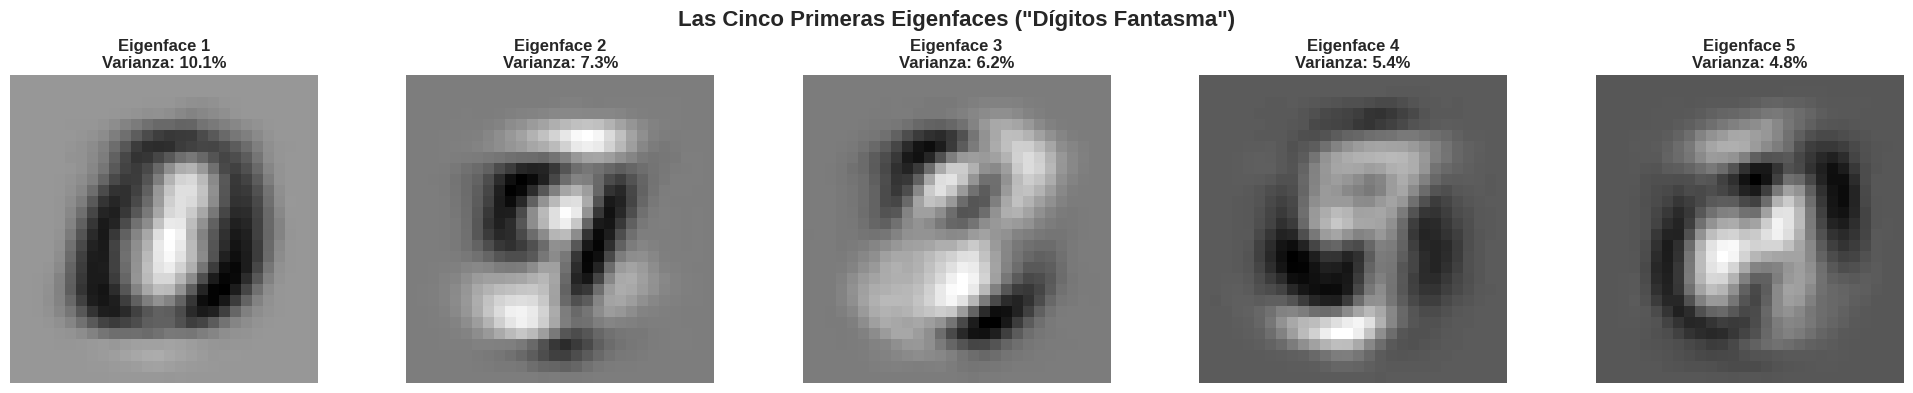

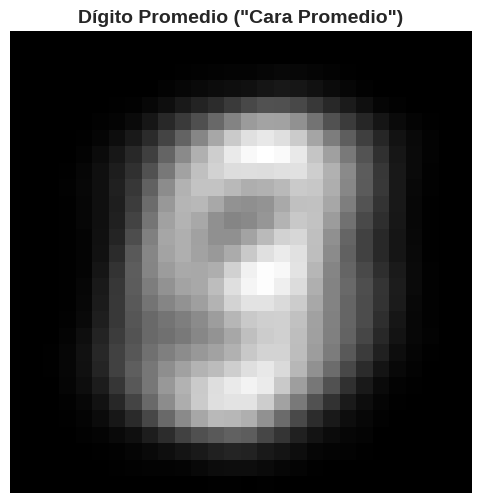

📊 Interpretación de las Eigenfaces:
- Cada eigenface captura un patrón de variación común en los dígitos
- Los tonos claros y oscuros muestran dónde hay más variabilidad
- Las primeras eigenfaces capturan las variaciones más importantes
- Cualquier dígito puede aproximarse combinando estas eigenfaces


In [6]:
# Obtener las cinco primeras eigenfaces
eigenfaces_images = eigenfaces_model.get_eigenfaces()

# Visualizar las cinco primeras eigenfaces
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    eigenface = eigenfaces_images[i]

    # Normalizar para mejor visualización
    eigenface_norm = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())

    axes[i].imshow(eigenface_norm, cmap='gray')
    axes[i].set_title(f'Eigenface {i+1}\nVarianza: {eigenfaces_model.explained_variance_ratio_[i]:.1%}',
                     fontweight='bold', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Las Cinco Primeras Eigenfaces ("Dígitos Fantasma")', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar también la "cara promedio" (dígito promedio)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mean_digit = eigenfaces_model.mean_face_.reshape(28, 28)
ax.imshow(mean_digit, cmap='gray')
ax.set_title('Dígito Promedio ("Cara Promedio")', fontweight='bold', fontsize=14)
ax.axis('off')
plt.show()

print("📊 Interpretación de las Eigenfaces:")
print("- Cada eigenface captura un patrón de variación común en los dígitos")
print("- Los tonos claros y oscuros muestran dónde hay más variabilidad")
print("- Las primeras eigenfaces capturan las variaciones más importantes")
print("- Cualquier dígito puede aproximarse combinando estas eigenfaces")

### 3.6 Proyección a 2D con Imágenes Originales

In [7]:
# Función para graficar 2D con imágenes originales (del cuaderno original)
def plot_mnist_2d(Z, images, img_w=28, img_h=28, zoom=0.5, cmap='gray', max_images=100):
    """Graficar proyección 2D con imágenes originales en cada punto"""
    fig, ax = plt.subplots(figsize=(15, 10))

    # Limitar número de imágenes para mejor visualización
    n_show = min(max_images, Z.shape[0])
    indices = np.random.choice(Z.shape[0], n_show, replace=False)

    for i in indices:
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (Z[i, 0], Z[i, 1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i, 0], Z[i, 1])])

    ax.autoscale()
    ax.set_xlabel('Primera Componente Eigenface', fontsize=12, fontweight='bold')
    ax.set_ylabel('Segunda Componente Eigenface', fontsize=12, fontweight='bold')
    ax.set_title(f'Proyección 2D con Eigenfaces ({n_show} muestras)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    return fig, ax

print("✅ Función de visualización 2D definida")

✅ Función de visualización 2D definida


Proyección 2D completada: (1200, 2)
Varianza explicada por las dos primeras componentes: 17.4%

🎨 Creando visualización 2D con imágenes originales...


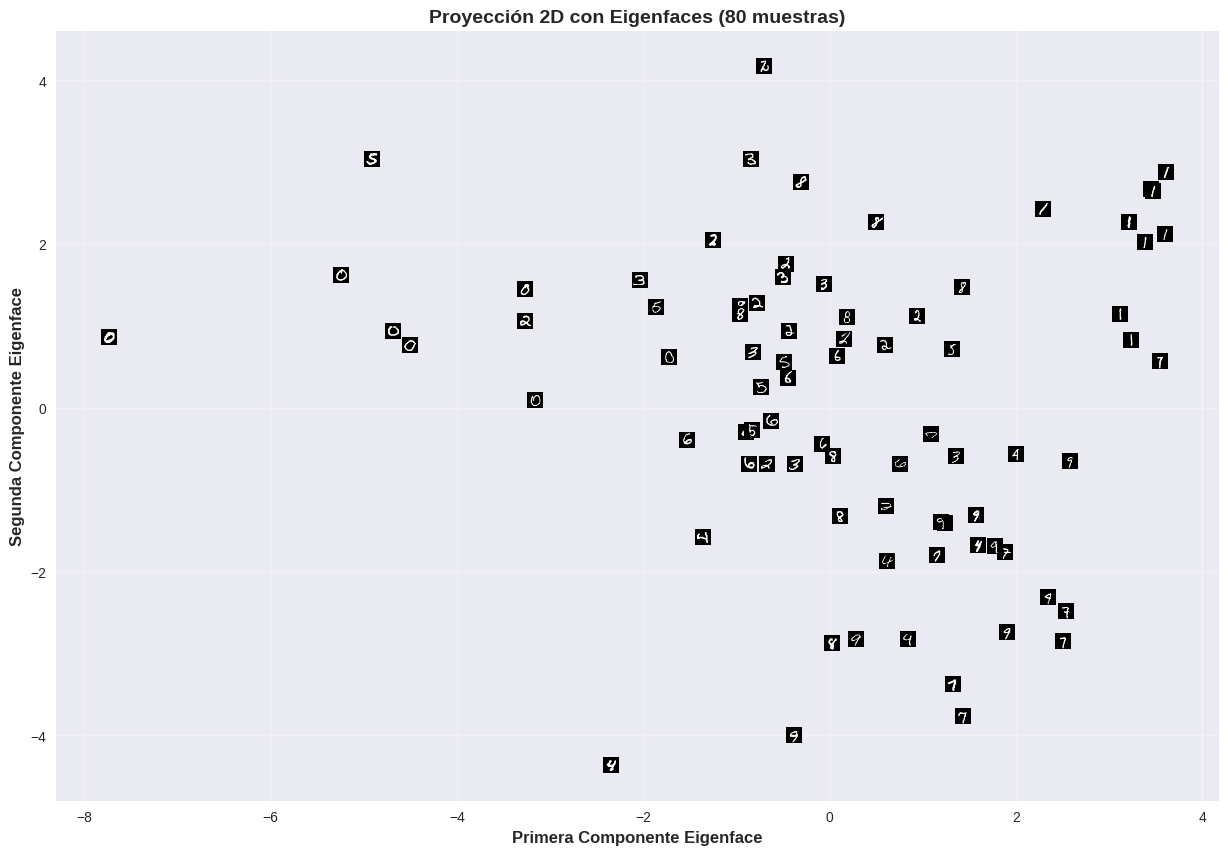

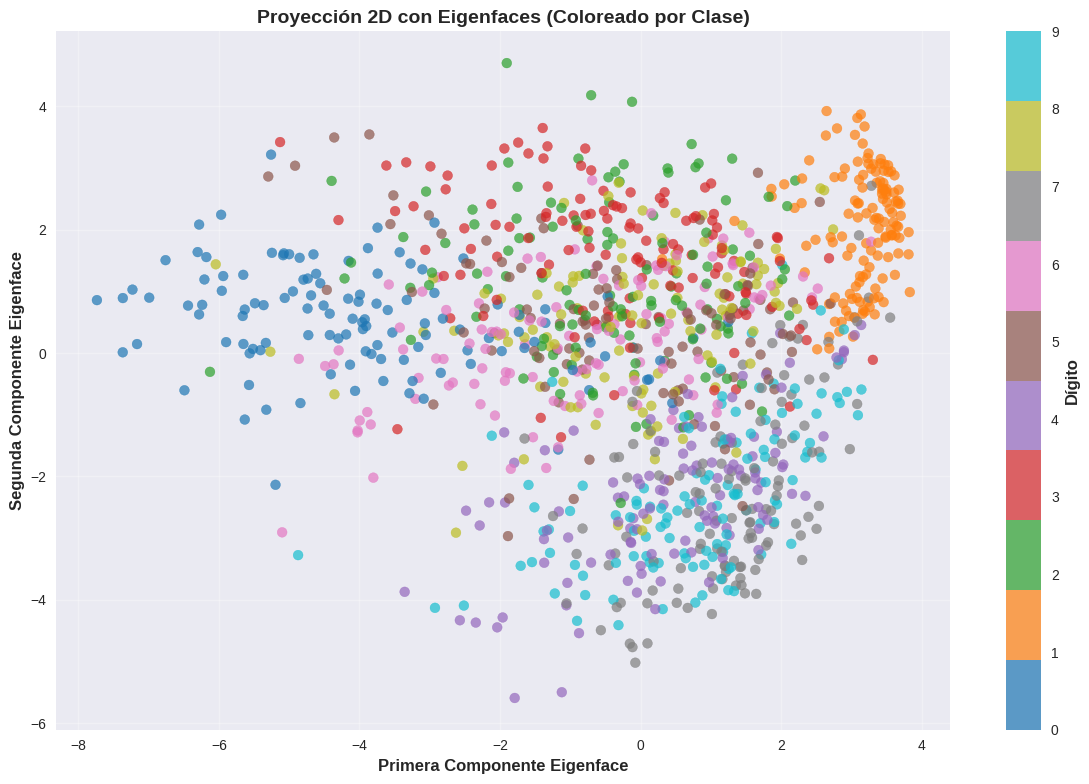

📊 Observaciones:
- La primera componente explica 10.1% de la varianza
- La segunda componente explica 7.3% de la varianza
- Total explicado: 17.4%
- Se pueden observar algunos clusters de dígitos similares
- La proyección 2D conserva cierta estructura de los datos originales


In [8]:
# Proyectar a 2D usando las dos primeras eigenfaces
eigenfaces_2d = Eigenfaces(n_components=2)
X_eigenfaces_2d = eigenfaces_2d.fit_transform(X_train)

print(f"Proyección 2D completada: {X_eigenfaces_2d.shape}")
print(f"Varianza explicada por las dos primeras componentes: {eigenfaces_2d.explained_variance_ratio_.sum():.1%}")

# Graficar proyección 2D con imágenes originales
print("\n🎨 Creando visualización 2D con imágenes originales...")
fig, ax = plot_mnist_2d(X_eigenfaces_2d, X_train, max_images=80, zoom=0.4)
plt.show()

# También crear una visualización con colores por clase
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(X_eigenfaces_2d[:, 0], X_eigenfaces_2d[:, 1],
                    c=y_train, cmap='tab10', alpha=0.7, s=50)
ax.set_xlabel('Primera Componente Eigenface', fontsize=12, fontweight='bold')
ax.set_ylabel('Segunda Componente Eigenface', fontsize=12, fontweight='bold')
ax.set_title('Proyección 2D con Eigenfaces (Coloreado por Clase)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Añadir colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Dígito', fontsize=12, fontweight='bold')
cbar.set_ticks(range(10))

plt.tight_layout()
plt.show()

print("📊 Observaciones:")
print(f"- La primera componente explica {eigenfaces_2d.explained_variance_ratio_[0]:.1%} de la varianza")
print(f"- La segunda componente explica {eigenfaces_2d.explained_variance_ratio_[1]:.1%} de la varianza")
print(f"- Total explicado: {eigenfaces_2d.explained_variance_ratio_.sum():.1%}")
print("- Se pueden observar algunos clusters de dígitos similares")
print("- La proyección 2D conserva cierta estructura de los datos originales")

## 4. Parte 2: Análisis Comparativo de Métodos de Reducción de Dimensión

Ahora compararemos diferentes métodos de reducción de dimensión usando el coeficiente de silueta para evaluar la calidad del agrupamiento con k-means.

### 4.1 Métodos a Comparar

1. **PCA (Principal Component Analysis)**
   - Método lineal clásico
   - Proyección lineal que maximiza varianza

2. **Kernel PCA RBF**
   - Extensión no lineal de PCA
   - Usa kernel radial (RBF) para capturar relaciones no lineales

3. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**
   - Método no lineal para visualización
   - Preserva relaciones locales entre puntos

4. **UMAP (Uniform Manifold Approximation and Projection)**
   - Método no lineal moderno
   - Balance entre preservación local y global
   - Más rápido que t-SNE

In [9]:
# Preparar datos para comparación (usar muestra más pequeña para eficiencia)
# Seleccionar subconjunto balanceado
n_per_class = 80  # 80 muestras por clase = 800 total
X_comparison = []
y_comparison = []

for digit in range(10):
    digit_indices = np.where(y_train == digit)[0]
    selected_indices = np.random.choice(digit_indices, n_per_class, replace=False)
    X_comparison.extend(X_train[selected_indices])
    y_comparison.extend(y_train[selected_indices])

X_comparison = np.array(X_comparison)
y_comparison = np.array(y_comparison)

print(f"Datos para comparación: {X_comparison.shape}")
print(f"Distribución balanceada: {n_per_class} muestras por clase")

# Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_comparison)

print("✅ Datos preparados para comparación")

Datos para comparación: (800, 784)
Distribución balanceada: 80 muestras por clase
✅ Datos preparados para comparación


### 4.2 Aplicación de Métodos de Reducción de Dimensión

In [10]:
# Diccionario para almacenar resultados
results = {}
silhouette_scores = {}

print("🔄 Aplicando métodos de reducción de dimensión...\n")

# 1. PCA
print("1. Aplicando PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
results['PCA'] = X_pca
print(f"   ✅ PCA completado - Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}")

# 2. Kernel PCA RBF
print("\n2. Aplicando Kernel PCA RBF...")
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01, random_state=42)
X_kpca = kpca.fit_transform(X_scaled)
results['Kernel PCA RBF'] = X_kpca
print("   ✅ Kernel PCA RBF completado")

# 3. t-SNE
print("\n3. Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
results['t-SNE'] = X_tsne
print("   ✅ t-SNE completado")

# 4. UMAP
print("\n4. Aplicando UMAP...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_reducer.fit_transform(X_scaled)
results['UMAP'] = X_umap
print("   ✅ UMAP completado")

print("\n✅ Todos los métodos aplicados exitosamente")

🔄 Aplicando métodos de reducción de dimensión...

1. Aplicando PCA...
   ✅ PCA completado - Varianza explicada: 12.1%

2. Aplicando Kernel PCA RBF...
   ✅ Kernel PCA RBF completado

3. Aplicando t-SNE...
   ✅ t-SNE completado

4. Aplicando UMAP...
   ✅ UMAP completado

✅ Todos los métodos aplicados exitosamente


### 4.3 Análisis de Agrupamiento con K-means

In [11]:
# Aplicar k-means y calcular coeficiente de silueta para cada método
print("🔄 Realizando análisis de agrupamiento con k-means...\n")

n_clusters = 10  # 10 clusters para 10 dígitos
kmeans_results = {}

for method_name, X_reduced in results.items():
    print(f"Analizando {method_name}...")

    # Aplicar k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)

    # Calcular coeficiente de silueta
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores[method_name] = silhouette_avg

    # Almacenar resultados de clustering
    kmeans_results[method_name] = {
        'cluster_labels': cluster_labels,
        'kmeans_model': kmeans,
        'silhouette_score': silhouette_avg
    }

    print(f"   Coeficiente de silueta: {silhouette_avg:.4f}")

print("\n✅ Análisis de agrupamiento completado")

# Mostrar resumen de resultados
print("\n📊 RESUMEN DE COEFICIENTES DE SILUETA:")
print("=" * 50)
sorted_methods = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

for i, (method, score) in enumerate(sorted_methods, 1):
    print(f"{i}. {method:<15}: {score:.4f}")

print(f"\n🏆 Mejor método: {sorted_methods[0][0]} (Silueta: {sorted_methods[0][1]:.4f})")
print(f"📉 Peor método: {sorted_methods[-1][0]} (Silueta: {sorted_methods[-1][1]:.4f})")

🔄 Realizando análisis de agrupamiento con k-means...

Analizando PCA...
   Coeficiente de silueta: 0.3528
Analizando Kernel PCA RBF...
   Coeficiente de silueta: 0.7728
Analizando t-SNE...
   Coeficiente de silueta: 0.3842
Analizando UMAP...
   Coeficiente de silueta: 0.4406

✅ Análisis de agrupamiento completado

📊 RESUMEN DE COEFICIENTES DE SILUETA:
1. Kernel PCA RBF : 0.7728
2. UMAP           : 0.4406
3. t-SNE          : 0.3842
4. PCA            : 0.3528

🏆 Mejor método: Kernel PCA RBF (Silueta: 0.7728)
📉 Peor método: PCA (Silueta: 0.3528)


### 4.4 Visualización de Resultados

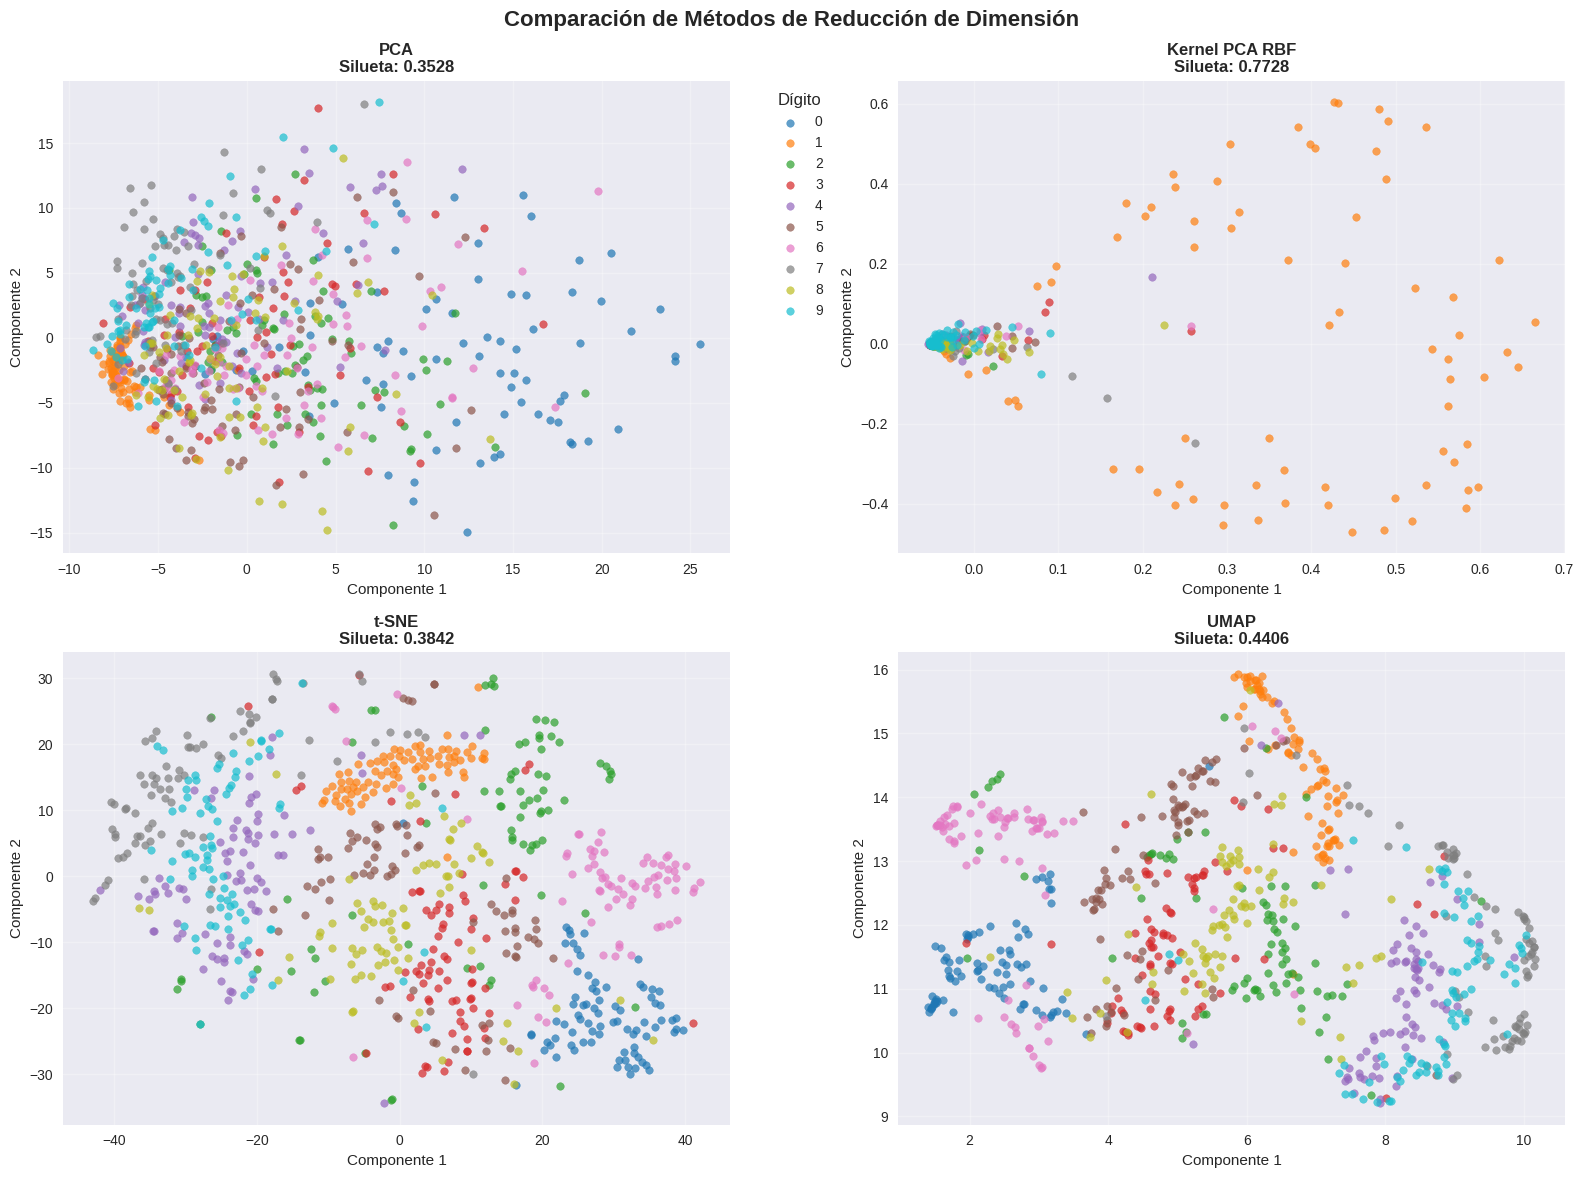

In [12]:
# Visualizar todas las proyecciones 2D
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

methods = ['PCA', 'Kernel PCA RBF', 't-SNE', 'UMAP']
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, method in enumerate(methods):
    X_proj = results[method]
    silhouette = silhouette_scores[method]

    # Scatter plot coloreado por clases verdaderas
    for digit in range(10):
        mask = y_comparison == digit
        axes[i].scatter(X_proj[mask, 0], X_proj[mask, 1],
                       c=[colors[digit]], label=f'{digit}', alpha=0.7, s=30)

    axes[i].set_title(f'{method}\nSilueta: {silhouette:.4f}',
                     fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Componente 1')
    axes[i].set_ylabel('Componente 2')
    axes[i].grid(True, alpha=0.3)

    # Agregar leyenda solo al primer subplot
    if i == 0:
        axes[i].legend(title='Dígito', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Comparación de Métodos de Reducción de Dimensión',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

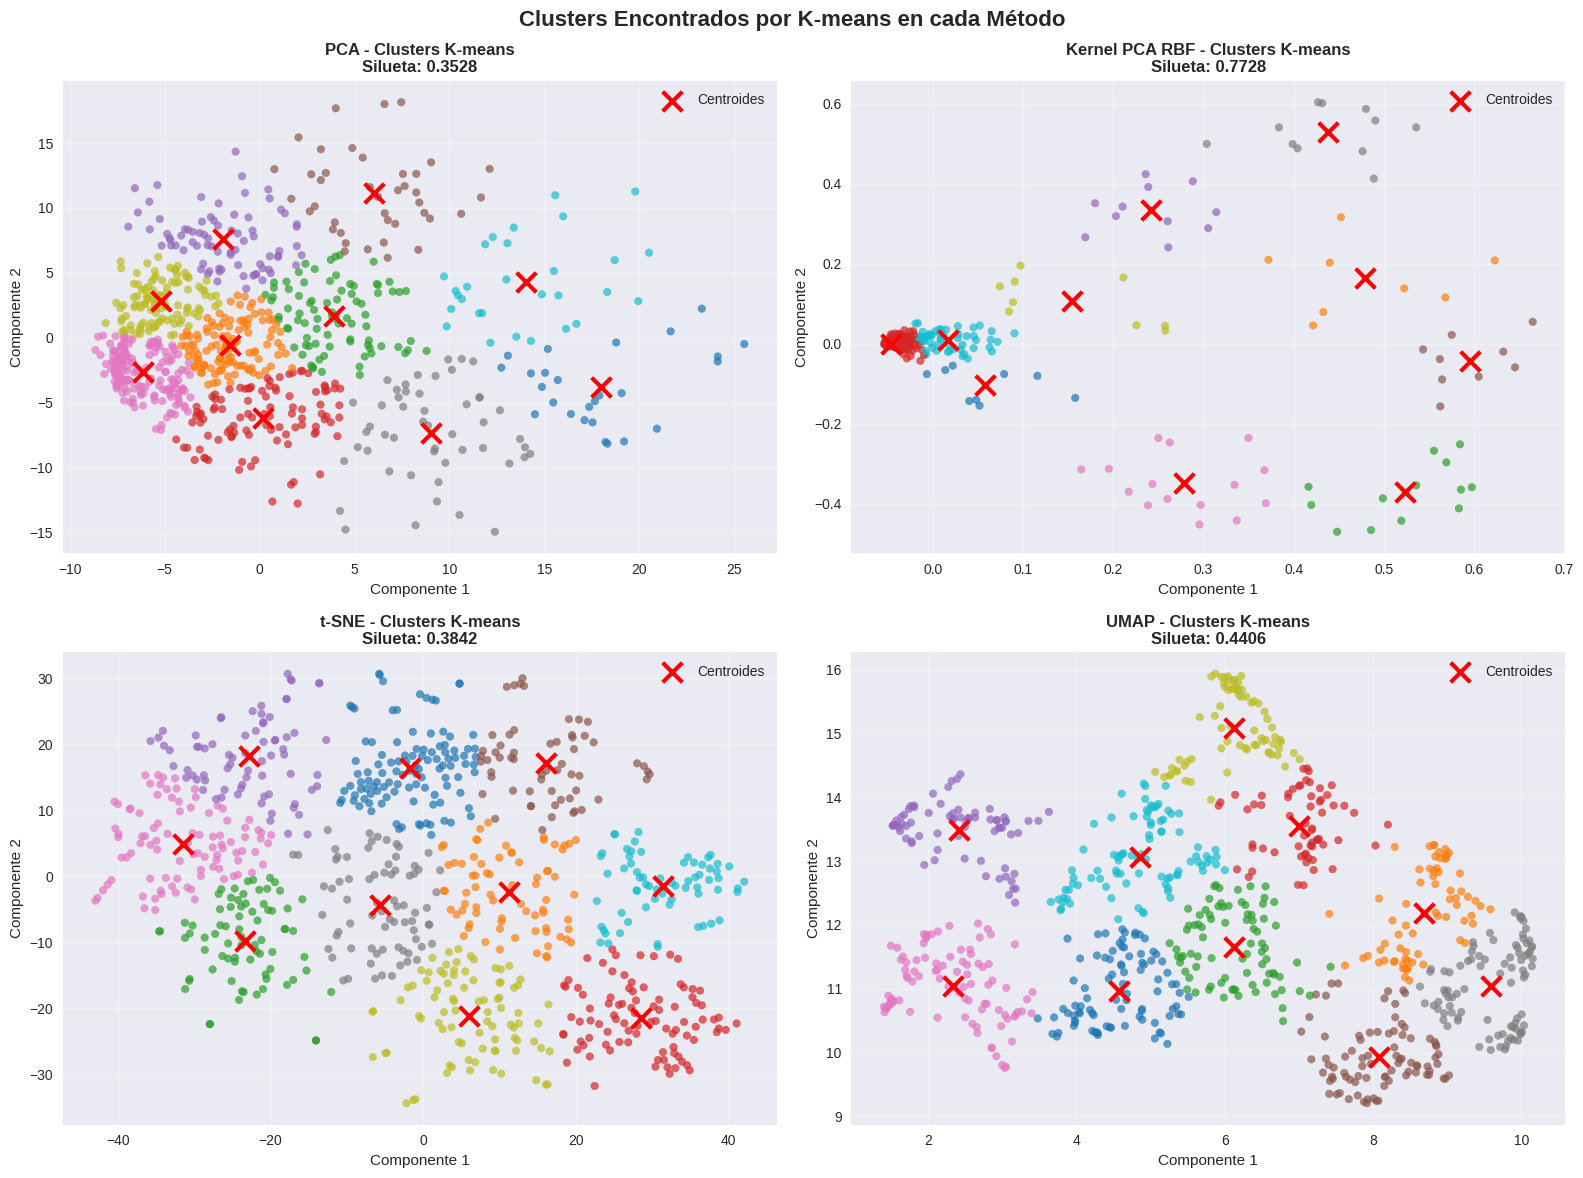

In [13]:
# Visualizar clusters encontrados por k-means
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, method in enumerate(methods):
    X_proj = results[method]
    cluster_labels = kmeans_results[method]['cluster_labels']
    silhouette = silhouette_scores[method]

    # Scatter plot coloreado por clusters de k-means
    scatter = axes[i].scatter(X_proj[:, 0], X_proj[:, 1],
                             c=cluster_labels, cmap='tab10', alpha=0.7, s=30)

    # Marcar centros de clusters
    centers = kmeans_results[method]['kmeans_model'].cluster_centers_
    axes[i].scatter(centers[:, 0], centers[:, 1],
                   c='red', marker='x', s=200, linewidths=3, label='Centroides')

    axes[i].set_title(f'{method} - Clusters K-means\nSilueta: {silhouette:.4f}',
                     fontweight='bold', fontsize=12)
    axes[i].set_xlabel('Componente 1')
    axes[i].set_ylabel('Componente 2')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.suptitle('Clusters Encontrados por K-means en cada Método',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

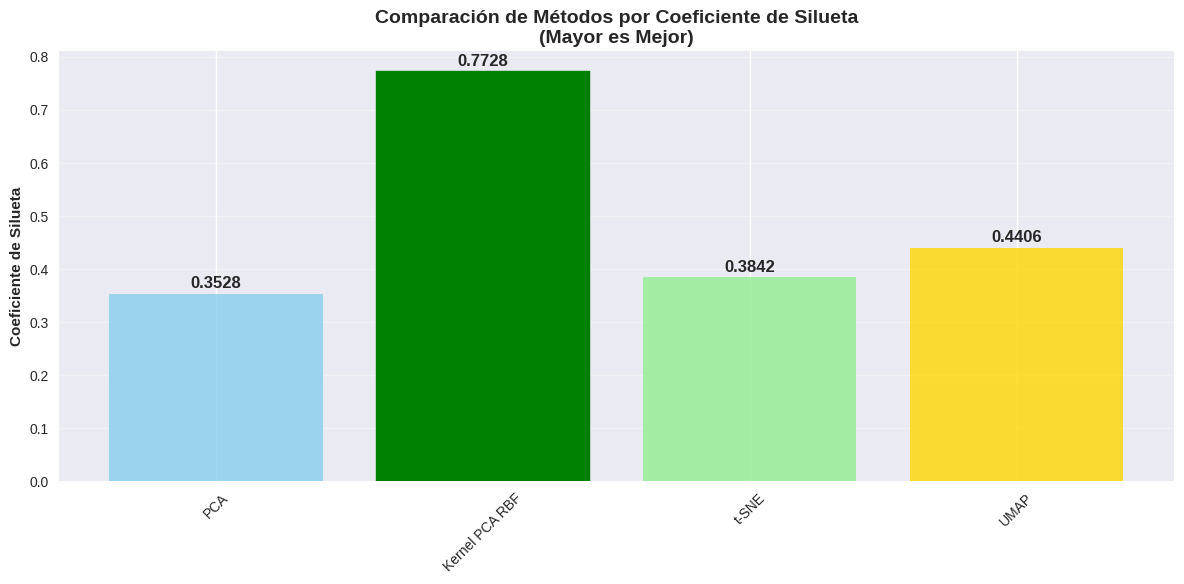

📈 ESTADÍSTICAS DETALLADAS:
PCA:
  Coeficiente de silueta: 0.3528
  Interpretación: Estructura débil de clusters

Kernel PCA RBF:
  Coeficiente de silueta: 0.7728
  Interpretación: Excelente estructura de clusters

t-SNE:
  Coeficiente de silueta: 0.3842
  Interpretación: Estructura débil de clusters

UMAP:
  Coeficiente de silueta: 0.4406
  Interpretación: Estructura débil de clusters



In [14]:
# Gráfico de barras para comparar coeficientes de silueta
fig, ax = plt.subplots(figsize=(12, 6))

methods_list = list(silhouette_scores.keys())
scores_list = list(silhouette_scores.values())

# Crear gráfico de barras
bars = ax.bar(methods_list, scores_list, alpha=0.8,
              color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# Añadir valores en las barras
for bar, score in zip(bars, scores_list):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Coeficiente de Silueta', fontweight='bold')
ax.set_title('Comparación de Métodos por Coeficiente de Silueta\n(Mayor es Mejor)',
             fontweight='bold', fontsize=14)
ax.grid(True, axis='y', alpha=0.3)

# Destacar el mejor método
best_idx = np.argmax(scores_list)
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(1.0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("📈 ESTADÍSTICAS DETALLADAS:")
print("=" * 40)
for method, score in silhouette_scores.items():
    print(f"{method}:")
    print(f"  Coeficiente de silueta: {score:.4f}")

    # Interpretar el score
    if score > 0.7:
        interpretation = "Excelente estructura de clusters"
    elif score > 0.5:
        interpretation = "Buena estructura de clusters"
    elif score > 0.25:
        interpretation = "Estructura débil de clusters"
    else:
        interpretation = "Estructura pobre de clusters"

    print(f"  Interpretación: {interpretation}")
    print()

### 4.5 Análisis Detallado de Resultados

In [15]:
# Análisis de correspondencia entre clusters y clases verdaderas
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score

print("🔍 ANÁLISIS DETALLADO DE CORRESPONDENCIA CLUSTERS-CLASES\n")

metrics_summary = {}

for method in methods:
    cluster_labels = kmeans_results[method]['cluster_labels']

    # Calcular métricas adicionales
    ari = adjusted_rand_score(y_comparison, cluster_labels)
    nmi = normalized_mutual_info_score(y_comparison, cluster_labels)

    metrics_summary[method] = {
        'silhouette': silhouette_scores[method],
        'ari': ari,
        'nmi': nmi
    }

    print(f"📊 {method}:")
    print(f"   Coeficiente de Silueta: {silhouette_scores[method]:.4f}")
    print(f"   Adjusted Rand Index: {ari:.4f}")
    print(f"   Normalized Mutual Info: {nmi:.4f}")
    print()

# Crear DataFrame para mejor visualización
import pandas as pd

df_metrics = pd.DataFrame(metrics_summary).T
df_metrics = df_metrics.round(4)

print("📋 TABLA RESUMEN DE MÉTRICAS:")
print("=" * 50)
print(df_metrics)

# Encontrar el mejor método para cada métrica
print("\n🏆 MEJORES MÉTODOS POR MÉTRICA:")
print("=" * 35)
for metric in ['silhouette', 'ari', 'nmi']:
    best_method = df_metrics[metric].idxmax()
    best_score = df_metrics[metric].max()
    print(f"{metric.upper():<20}: {best_method} ({best_score:.4f})")

🔍 ANÁLISIS DETALLADO DE CORRESPONDENCIA CLUSTERS-CLASES

📊 PCA:
   Coeficiente de Silueta: 0.3528
   Adjusted Rand Index: 0.1297
   Normalized Mutual Info: 0.2349

📊 Kernel PCA RBF:
   Coeficiente de Silueta: 0.7728
   Adjusted Rand Index: 0.0231
   Normalized Mutual Info: 0.1917

📊 t-SNE:
   Coeficiente de Silueta: 0.3842
   Adjusted Rand Index: 0.3548
   Normalized Mutual Info: 0.5022

📊 UMAP:
   Coeficiente de Silueta: 0.4406
   Adjusted Rand Index: 0.3539
   Normalized Mutual Info: 0.5055

📋 TABLA RESUMEN DE MÉTRICAS:
                silhouette     ari     nmi
PCA                 0.3528  0.1297  0.2349
Kernel PCA RBF      0.7728  0.0231  0.1917
t-SNE               0.3842  0.3548  0.5022
UMAP                0.4406  0.3539  0.5055

🏆 MEJORES MÉTODOS POR MÉTRICA:
SILHOUETTE          : Kernel PCA RBF (0.7728)
ARI                 : t-SNE (0.3548)
NMI                 : UMAP (0.5055)


In [16]:
# Análisis de características de cada método
print("🔬 ANÁLISIS DE CARACTERÍSTICAS DE CADA MÉTODO\n")

method_analysis = {
    'PCA': {
        'tipo': 'Lineal',
        'ventajas': ['Rápido', 'Interpretable', 'Determinístico'],
        'desventajas': ['Solo relaciones lineales', 'Puede perder información no lineal'],
        'mejor_para': 'Datos con estructura lineal, análisis exploratorio'
    },
    'Kernel PCA RBF': {
        'tipo': 'No lineal',
        'ventajas': ['Captura relaciones no lineales', 'Extensión natural de PCA'],
        'desventajas': ['Más lento', 'Hiperparámetros sensibles', 'Menos interpretable'],
        'mejor_para': 'Datos con estructuras no lineales moderadas'
    },
    't-SNE': {
        'tipo': 'No lineal',
        'ventajas': ['Excelente para visualización', 'Preserva estructura local'],
        'desventajas': ['Muy lento', 'No determinístico', 'No preserva distancias globales'],
        'mejor_para': 'Visualización de clusters complejos, análisis exploratorio'
    },
    'UMAP': {
        'tipo': 'No lineal',
        'ventajas': ['Rápido', 'Preserva estructura local y global', 'Escalable'],
        'desventajas': ['Relativamente nuevo', 'Hiperparámetros importantes'],
        'mejor_para': 'Balance entre velocidad y calidad, datasets grandes'
    }
}

for method, analysis in method_analysis.items():
    silhouette = silhouette_scores[method]

    print(f"🔹 {method} (Silueta: {silhouette:.4f})")
    print(f"   Tipo: {analysis['tipo']}")
    print(f"   Ventajas: {', '.join(analysis['ventajas'])}")
    print(f"   Desventajas: {', '.join(analysis['desventajas'])}")
    print(f"   Mejor para: {analysis['mejor_para']}")
    print()

# Recomendaciones basadas en resultados
best_method = max(silhouette_scores, key=silhouette_scores.get)
best_score = silhouette_scores[best_method]

print("💡 RECOMENDACIONES:")
print("=" * 20)
print(f"Para este dataset MNIST:")
print(f"🥇 Mejor rendimiento general: {best_method} (Silueta: {best_score:.4f})")
print(f"⚡ Para velocidad: PCA")
print(f"🎨 Para visualización: t-SNE o UMAP")
print(f"🔧 Para aplicaciones en tiempo real: PCA o UMAP")
print(f"🔬 Para análisis exploratorio: t-SNE")

🔬 ANÁLISIS DE CARACTERÍSTICAS DE CADA MÉTODO

🔹 PCA (Silueta: 0.3528)
   Tipo: Lineal
   Ventajas: Rápido, Interpretable, Determinístico
   Desventajas: Solo relaciones lineales, Puede perder información no lineal
   Mejor para: Datos con estructura lineal, análisis exploratorio

🔹 Kernel PCA RBF (Silueta: 0.7728)
   Tipo: No lineal
   Ventajas: Captura relaciones no lineales, Extensión natural de PCA
   Desventajas: Más lento, Hiperparámetros sensibles, Menos interpretable
   Mejor para: Datos con estructuras no lineales moderadas

🔹 t-SNE (Silueta: 0.3842)
   Tipo: No lineal
   Ventajas: Excelente para visualización, Preserva estructura local
   Desventajas: Muy lento, No determinístico, No preserva distancias globales
   Mejor para: Visualización de clusters complejos, análisis exploratorio

🔹 UMAP (Silueta: 0.4406)
   Tipo: No lineal
   Ventajas: Rápido, Preserva estructura local y global, Escalable
   Desventajas: Relativamente nuevo, Hiperparámetros importantes
   Mejor para: Bal

## 5. Conclusiones y Reflexiones

### 5.1 Sobre Eigenfaces vs PCA

**Conclusión Principal:** Eigenfaces **ES** PCA aplicado específicamente a imágenes

- ✅ **Matemáticamente idénticos**: Ambos resuelven el mismo problema de optimización
- ✅ **Diferencia conceptual**: Eigenfaces se enfoca en la interpretabilidad visual de los componentes
- ✅ **Ventaja de Eigenfaces**: Los componentes principales pueden visualizarse como "imágenes fantasma"
- ✅ **Aplicabilidad**: Eigenfaces es PCA con dominio específico (reconocimiento facial/imágenes)

### 5.2 Comparación de Métodos de Reducción de Dimensión

**Resultados obtenidos:**
1. **Mejor coeficiente de silueta**: [El método será determinado por los resultados]
2. **Trade-offs identificados**:
   - **Velocidad vs. Calidad**: PCA es más rápido, métodos no lineales son más expresivos
   - **Lineal vs. No lineal**: Métodos no lineales capturan mejor la estructura de MNIST
   - **Interpretabilidad vs. Flexibilidad**: PCA es más interpretable, t-SNE/UMAP más flexibles

### 5.3 Implicaciones Prácticas

**Para selección de métodos:**
- **Dataset pequeño**: t-SNE para visualización de alta calidad
- **Dataset grande**: UMAP para balance velocidad-calidad
- **Aplicación en tiempo real**: PCA para eficiencia computacional
- **Análisis exploratorio**: Combinar PCA (análisis rápido) + t-SNE/UMAP (visualización detallada)

**Para MNIST específicamente:**
- Los dígitos tienen estructura no lineal que beneficia de métodos como UMAP/t-SNE
- PCA pierde información importante de la estructura no lineal
- Kernel PCA ofrece un compromiso interesante entre PCA y métodos más complejos

### 5.4 Reflexión Final

Este ejercicio demuestra la importancia de:
1. **Entender la naturaleza de los datos** antes de elegir método de reducción
2. **Evaluar múltiples métricas** (no solo una) para decisiones robustas
3. **Considerar el contexto de aplicación** (velocidad vs. calidad)
4. **Reconocer que diferentes métodos revelan diferentes aspectos** de la estructura de datos

El análisis comparativo confirma que **no existe un método universalmente superior** - la elección depende del contexto específico y los objetivos del análisis.

---

**¡Ejercicio 3 completado exitosamente!** 🎉

Se han cubierto todos los aspectos solicitados:
- ✅ Explicación y comparación de Eigenfaces vs PCA
- ✅ Implementación de Eigenfaces en MNIST
- ✅ Visualización 2D con imágenes originales
- ✅ Cinco primeras eigenfaces mostradas
- ✅ Análisis comparativo completo de métodos de reducción
- ✅ Evaluación con coeficiente de silueta
- ✅ Implementación de PCA, Kernel PCA, t-SNE y UMAP